In [1]:
%%time
import numpy as np 
import pandas as pd
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
import time
from tqdm import tqdm, tqdm_notebook; tqdm.pandas()
from sklearn.metrics import label_ranking_average_precision_score
from sklearn.model_selection import train_test_split
from filtr import Filtr
import random
import cv2

Wall time: 36.7 s


In [8]:
# load audio files
Data_path = "D:\\Documents\\Atom\\myrepos\\Filtr\\Filtr\\Audio"
Categories = ['Kick','Snare']
os.chdir("D:\\Documents\\Atom\\myrepos\\Filtr\\Filtr")
f = Filtr(Data_path,dest = None)

snare = []
kick = []

for category in Categories:
    path = os.path.join(Data_path,category)
    files = f.files(path)
    os.chdir(path)
    print(category)
    for file in tqdm(files):
        if ('DK' or 'Kick' or 'kick') in file:
            full_path = os.path.join(path,file)
            kick.append(full_path)
        elif ("DS" or 'snare') in file:
            full_path = os.path.join(path,file)
            snare.append(full_path) 

Kick


100%|███████████████████████████████████████████████████████████████████████████| 3147/3147 [00:00<00:00, 50086.42it/s]


Snare


100%|███████████████████████████████████████████████████████████████████████████| 5415/5415 [00:00<00:00, 58381.80it/s]


In [9]:
# read each sample as audio data
import soundfile as sf
import sys

def trim(y,samples = 44100):
    if 0 < len(y): # workaround: 0 length causes error
        y, _ = librosa.effects.trim(y)
    return y

def audio_data(training_names):
    audio_info = []
    error = 0
    
    
    for name in tqdm(training_names):
        try:
            # loading the data
            
            data, samplerate = sf.read(name)
            #print(f"Data before: {data}\n")
            
            data = data[:, 0]
            #print(f"Data after: {data}")
            
            # optional trim silence
            data = trim(data)
            
            audio_info.append(data)
            #print(f"filename: {name}")
            
        except:
            #print(e)
            error += 1
            #print(f"there was an error loading this file: {name}")
            #print("Unexpected error:", sys.exc_info()[0])
            #print()
            #raise
            continue
            
    print(f"there was an error loading {error} files")    
    return np.array(audio_info)

In [10]:
%%time
K_data = audio_data(kick)
S_data = audio_data(snare)

100%|██████████████████████████████████████████████████████████████████████████████| 3147/3147 [01:22<00:00, 38.18it/s]


there was an error loading 171 files


  4%|███                                                                            | 192/4966 [00:05<02:09, 36.80it/s]

KeyboardInterrupt: 

In [5]:
print(len(K_data))
print(len(S_data))

2976
4584


In [6]:
# convert audio data into a Mel spectrogram 
def normalize(img):
    '''
    Normalizes an array 
    (subtract mean and divide by standard deviation)
    '''
    eps = 0.001
    if np.std(img) != 0:
        img = (img - np.mean(img)) / np.std(img)
    else:
        img = (img - np.mean(img)) / eps
    return img


def mel(audio,sr = 44100,size = 128,n_mels = 128,hop_length = 512,N_FFT = 2048):
    spectrograms = []
    error = []
    for data in tqdm(audio):    
        try:
            mel = librosa.feature.melspectrogram(y = data, sr = sr,n_mels = n_mels,hop_length=hop_length,
                                                n_fft = N_FFT)
            mel = librosa.power_to_db(mel,np.max).astype(np.float32)               
            #print(f"after: {mel.shape}")
            spectrograms.append(mel)
        except:
            error.append(data)
            continue
        
    if len(error) > 0:
        print(f"there was {len(error)} errors. this is the data \n{error}")
    return spectrograms  

In [7]:
%%time
kmels = mel(K_data)
smels = mel(S_data)

100%|█████████████████████████████████████████████████████████████████████████████| 4584/4584 [00:35<00:00, 130.92it/s]


there was 2 errors. this is the data 
[array([], dtype=float64), array([], dtype=float64)]
Wall time: 58 s


In [8]:
print(kmels[2])

[[-40.842304  -34.27965   -22.034145  ... -51.45462   -80.
  -80.       ]
 [-38.554817  -23.158197   -9.171838  ... -51.325993  -80.
  -80.       ]
 [-28.281363  -14.983322   -3.2803984 ... -55.136086  -80.
  -80.       ]
 ...
 [-63.96781   -69.95927   -80.        ... -80.        -80.
  -80.       ]
 [-64.755     -70.75493   -80.        ... -80.        -80.
  -80.       ]
 [-64.63777   -70.64305   -80.        ... -80.        -80.
  -80.       ]]


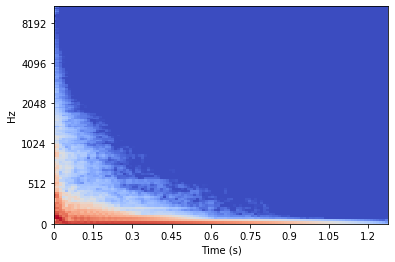

In [27]:
img = librosa.display.specshow(normalize(kmels[9]),y_axis = 'mel',x_axis = 's',sr=44100)

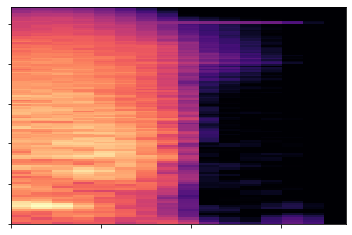

In [100]:
librosa.display.specshow(smels[0],y_axis = 'mel',x_axis = 's',sr=44100)

In [17]:
normalize(kmels[1]).shape

(128, 36)

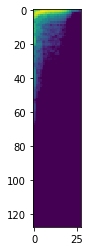

In [41]:
img = plt.imshow(kmels[4])

In [75]:
def save_image(audio_data,category,limit = None):
    sr = 44100
    os.chdir("D:\Documents\Atom\myrepos\Filtr\Filtr")
    limit = len(audio_data) if limit is None else limit
    count = 0
    for data in tqdm(audio_data[:limit]):
        

        plt.figure(figsize=(18,5))
        fig = plt.figure()
        
        
        librosa.display.specshow(data,sr=sr);
        #img = create_image(k);
        #print(count,img)
        #fig = plt.figure()
        fig.savefig(f'Images\\{category}\\{category.lower()}{count}.png', bbox_inches='tight', pad_inches = -.03)
        count += 1


In [76]:
save_image(kmels,'Kick')
save_image(smels,'Snare')


  0%|▏                                                                                | 9/2976 [00:00<03:35, 13.75it/s]D:\Documents\Anaconda\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if __name__ == '__main__':
D:\Documents\Anaconda\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.

100%|██████████████████████████████████████████████████████████████████████████████| 4582/4582 [06:58<00:00,  9.71it/s]

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x0000015757049A60> (for post_execute):


KeyboardInterrupt: 

<Figure size 1296x360 with 0 Axes>

Error in callback <function flush_figures at 0x0000015757054598> (for post_execute):


KeyboardInterrupt: 

In [16]:
%%time
import random
from skimage import color, io
from skimage.exposure import rescale_intensity
import os
def load_images(dpath,categories,IMG_SIZE = 128,limit = None):
    train = []

    for category in Categories:
        path = os.path.join(dpath,category)
        files = os.listdir(path)
        class_num = Categories.index(category)
        
        limit = len(files) if limit is None else limit
        if limit is None or limit < 0:
            raise ValueError(f"Limit cannot be {limit}")
        
        for img in tqdm(files[:limit]):
            #print(path)
            pic = os.path.join(path,img)
            #print(pic)
            img_data = io.imread(pic).astype('float32')
            img_data = cv2.resize(img_data,(IMG_SIZE,IMG_SIZE))
            #img_data.reshape(-1,128,128,1)
            img_data = rescale_intensity(color.rgb2gray(img_data))
            
            
            #cv2.imshow('dat',img_data)
            #print(img_data)
            #plt.imshow(img_data,cmap = 'gray')
            #plt.show()
            train.append([img_data,class_num])
    random.shuffle(train)    
    return train

    

Wall time: 0 ns


In [ ]:
path = "D:\\Documents\\Atom\\myrepos\\Filtr\\Filtr\\Images"
Categories = ['Kick','Snare']
train = load_images(path,Categories,limit = 2900)

 94%|████████████████████████████████████████████████████████████████████████     | 2712/2900 [00:16<00:00, 207.78it/s]

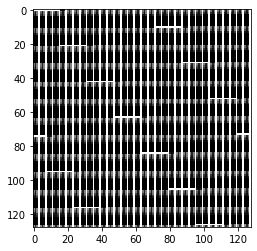

In [15]:
img = train[3][0]
#cv2.imshow('dat',img)
plt.imshow(img,cmap = 'gray') 
plt.show()

AttributeError: 'list' object has no attribute 'shape'

In [6]:
X = []
y = []

for f,l in train:
    X.append(f)
    y.append(l)

In [7]:
%%time
import pickle
os.chdir("D:/documents/atom/myrepos/Filtr/Filtr")
with open('X.pickle','wb') as file:
    pickle.dump(np.array(X),file)
    
with open('y.pickle','wb') as file:
    pickle.dump(np.array(y),file)

Wall time: 5.01 s
